# 08.2 Two-Stage Least Squares

**Chapter**: 8 - Instrumental Variables  
**Section**: 2 - Two-Stage Least Squares (2SLS)  
**Facure Source**: 08-Instrumental-Variables.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-09

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [Quarter of Birth Example](#11-quarter-of-birth-example)
   - 1.2 [The Two Stages](#12-the-two-stages)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [2SLS Derivation](#21-2sls-derivation)
   - 2.2 [Consistency Proof](#22-consistency-proof)
   - 2.3 [Standard Error Correction](#23-standard-error-correction)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [Angrist-Krueger Data](#31-angrist-krueger-data)
   - 3.2 [First Stage: Quarter of Birth → Education](#32-first-stage-quarter-of-birth--education)
   - 3.3 [Reduced Form: Quarter of Birth → Wage](#33-reduced-form-quarter-of-birth--wage)
   - 3.4 [IV by Hand vs Proper 2SLS](#34-iv-by-hand-vs-proper-2sls)
4. [Implementation](#4-implementation)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm,
    load_facure_data,
    set_notebook_style,
    ols_summary_table,
    create_tufte_figure,
    TUFTE_PALETTE,
)

import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS

set_notebook_style()

---

## 1. Facure's Intuition

> **Interview Relevance**: The 2SLS procedure is the workhorse of IV estimation. Interviewers test whether you understand *why* it works, not just *how* to run it.

### 1.1 Quarter of Birth Example

Facure uses the famous Angrist-Krueger (1991) example: estimating the causal effect of education on wages using **quarter of birth** as an instrument.

**Why quarter of birth?**

US compulsory attendance laws create an exogenous relationship:
- Kids must turn 6 by January 1 to enter school that year
- Kids must stay in school until they turn 16
- Result: Those born later in the year (Q3, Q4) have slightly *more* education when they can legally drop out

**Key assumption**: Quarter of birth is "as good as random" with respect to earnings potential—no astrology effects!

### 1.2 The Two Stages

**Stage 1 (First Stage)**: Regress treatment on instrument
$$\text{educ}_i = \gamma_0 + \gamma_1 \cdot \text{q4}_i + \boldsymbol{\gamma}_X X_i + v_i$$

**Stage 2 (Second Stage)**: Regress outcome on *fitted* treatment
$$\log(\text{wage})_i = \beta_0 + \kappa \cdot \widehat{\text{educ}}_i + \boldsymbol{\beta}_X X_i + u_i$$

★ Insight ─────────────────────────────────────
- First stage isolates "exogenous" variation in education (driven by quarter of birth)
- Second stage uses only this exogenous variation to estimate causal effect
- Key: Controls in second stage *must* also be in first stage
─────────────────────────────────────────────────

---

## 2. Formal Treatment

### 2.1 2SLS Derivation

Consider the structural equation with endogenous treatment $s_i$:

$$y_i = \alpha'X_i + \rho s_i + \eta_i$$

where $\text{Cov}(s_i, \eta_i) \neq 0$ (endogeneity).

**Step 1**: First-stage regression
$$s_i = \pi_0'X_i + \pi_1 z_i + \xi_i$$

where $z_i$ is an instrument satisfying:
- Relevance: $\pi_1 \neq 0$
- Exclusion: $\text{Cov}(z_i, \eta_i) = 0$

Fitted values: $\hat{s}_i = \hat{\pi}_0'X_i + \hat{\pi}_1 z_i$

**Step 2**: Second-stage regression
$$y_i = \alpha'X_i + \rho \hat{s}_i + [\eta_i + \rho(s_i - \hat{s}_i)]$$

The 2SLS estimator of $\rho$ is the OLS estimate from this regression.

### 2.2 Consistency Proof

**Claim**: $\hat{\rho}_{2SLS} \xrightarrow{p} \rho$

**Proof**:

The composite error term is $\tilde{\eta}_i = \eta_i + \rho(s_i - \hat{s}_i)$.

For consistency, we need $\text{Cov}(\hat{s}_i, \tilde{\eta}_i) = 0$.

1. $\text{Cov}(\hat{s}_i, \eta_i) = \text{Cov}(\hat{\pi}_0'X_i + \hat{\pi}_1 z_i, \eta_i) = 0$
   - By exogeneity of $X_i$ and $z_i$

2. $\text{Cov}(\hat{s}_i, s_i - \hat{s}_i) = \text{Cov}(\hat{s}_i, \xi_i) = 0$
   - Since $\hat{s}_i$ is a linear function of $X_i$ and $z_i$, uncorrelated with first-stage residuals

Therefore:
$$\text{Cov}(\hat{s}_i, \tilde{\eta}_i) = \text{Cov}(\hat{s}_i, \eta_i) + \rho \cdot \text{Cov}(\hat{s}_i, s_i - \hat{s}_i) = 0 \quad \blacksquare$$

### 2.3 Standard Error Correction

**Important**: Running 2SLS by hand gives **wrong** standard errors!

**Problem**: The residuals in stage 2 should be computed as:
$$\hat{u}_i = y_i - \hat{\alpha}'X_i - \hat{\rho} s_i \quad (\text{using actual } s_i)$$

NOT as:
$$\tilde{u}_i = y_i - \hat{\alpha}'X_i - \hat{\rho} \hat{s}_i \quad (\text{using fitted } \hat{s}_i)$$

Using $\tilde{u}_i$ (from manual 2SLS) gives residuals that are too small, leading to **underestimated** standard errors.

**Solution**: Use dedicated 2SLS software (e.g., `linearmodels.iv.IV2SLS`) that corrects for this.

$$\text{Var}(\hat{\rho}_{2SLS}) = \frac{\sigma^2_{\eta}}{n \cdot \text{Var}(\hat{s}_i)}$$

where $\sigma^2_{\eta}$ is estimated from actual residuals, not second-stage residuals.

---

## 3. Numeric Demonstration

### 3.1 Angrist-Krueger Data

In [2]:
# Load Angrist-Krueger quarter of birth data
data = load_facure_data('ak91.csv')

print(f"Sample size: n = {len(data):,}")
print(f"\nVariables:")
print(f"  - log_wage: {data['log_wage'].mean():.3f} (mean)")
print(f"  - years_of_schooling: {data['years_of_schooling'].mean():.2f} (mean)")
print(f"  - quarter_of_birth: {data['quarter_of_birth'].value_counts().sort_index().to_dict()}")

data.head()

Sample size: n = 329,509

Variables:
  - log_wage: 5.900 (mean)
  - years_of_schooling: 12.77 (mean)
  - quarter_of_birth: {1.0: 81671, 2.0: 80138, 3.0: 86856, 4.0: 80844}


,log_wage,years_of_schooling,year_of_birth,quarter_of_birth,state_of_birth
0,5.7900,12.0000,30.0000,1.0000,45.0000
1,5.9525,11.0000,30.0000,1.0000,45.0000
2,5.3159,12.0000,30.0000,1.0000,45.0000
3,5.5959,12.0000,30.0000,1.0000,45.0000
4,6.0689,12.0000,30.0000,1.0000,37.0000


In [3]:
# Create quarter dummies and grouping variable for plots
data = data.assign(
    q1=(data['quarter_of_birth'] == 1).astype(int),
    q2=(data['quarter_of_birth'] == 2).astype(int),
    q3=(data['quarter_of_birth'] == 3).astype(int),
    q4=(data['quarter_of_birth'] == 4).astype(int),
    time_of_birth=data['year_of_birth'] + data['quarter_of_birth']/4
)

# Aggregate by year and quarter for visualization
group_data = (data
    .groupby(['year_of_birth', 'quarter_of_birth'])
    [['log_wage', 'years_of_schooling']]
    .mean()
    .reset_index()
    .assign(time_of_birth=lambda d: d['year_of_birth'] + d['quarter_of_birth']/4)
)

### 3.2 First Stage: Quarter of Birth → Education

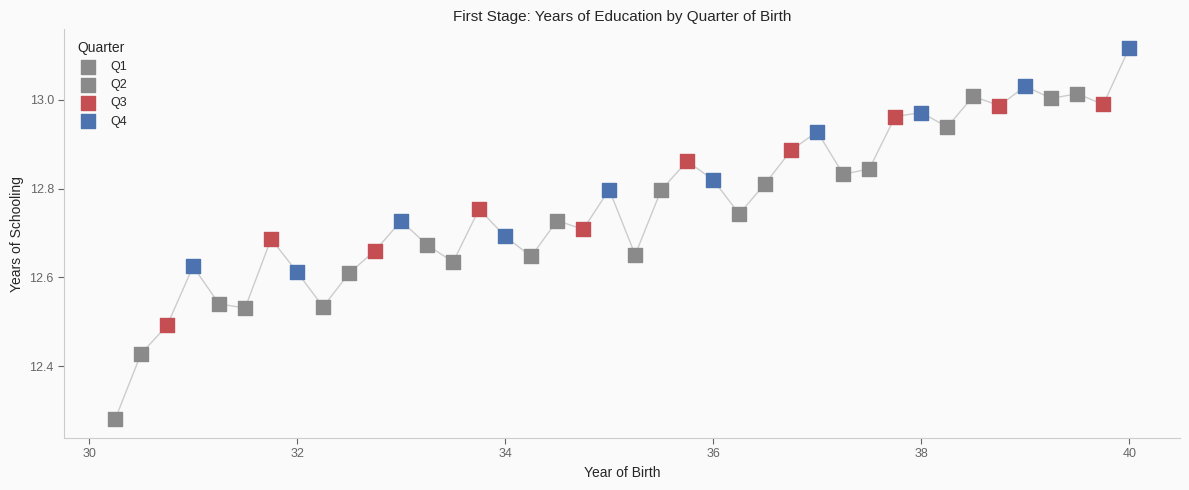

In [4]:
# Visualize first stage: seasonal pattern in education
fig, ax = create_tufte_figure(figsize=(12, 5))

ax.plot(group_data['time_of_birth'], group_data['years_of_schooling'], 
        color=TUFTE_PALETTE['spine'], zorder=-1, linewidth=1)

colors = [TUFTE_PALETTE['control'], TUFTE_PALETTE['secondary'], 
          TUFTE_PALETTE['effect'], TUFTE_PALETTE['treatment']]

for q in range(1, 5):
    subset = group_data.query(f'quarter_of_birth == {q}')
    ax.scatter(subset['time_of_birth'], subset['years_of_schooling'], 
               s=100, c=colors[q-1], marker='s', label=f'Q{q}', zorder=2)

ax.set_xlabel('Year of Birth')
ax.set_ylabel('Years of Schooling')
ax.set_title('First Stage: Years of Education by Quarter of Birth')
ax.legend(frameon=False, title='Quarter')

plt.tight_layout()
plt.show()

In [5]:
# First stage regression
first_stage = smf.ols(
    'years_of_schooling ~ C(year_of_birth) + C(state_of_birth) + q4',
    data=data
).fit()

print("FIRST STAGE: years_of_schooling ~ q4 + controls")
print("=" * 50)
print(f"q4 coefficient: {first_stage.params['q4']:.6f}")
print(f"q4 std error:   {first_stage.bse['q4']:.6f}")
print(f"q4 t-statistic: {first_stage.tvalues['q4']:.2f}")
print(f"q4 p-value:     {first_stage.pvalues['q4']:.2e}")
print(f"\nInterpretation: Those born in Q4 have {first_stage.params['q4']:.2f} more years of education")

FIRST STAGE: years_of_schooling ~ q4 + controls
q4 coefficient: 0.100858
q4 std error:   0.012904
q4 t-statistic: 7.82
q4 p-value:     5.46e-15

Interpretation: Those born in Q4 have 0.10 more years of education


### 3.3 Reduced Form: Quarter of Birth → Wage

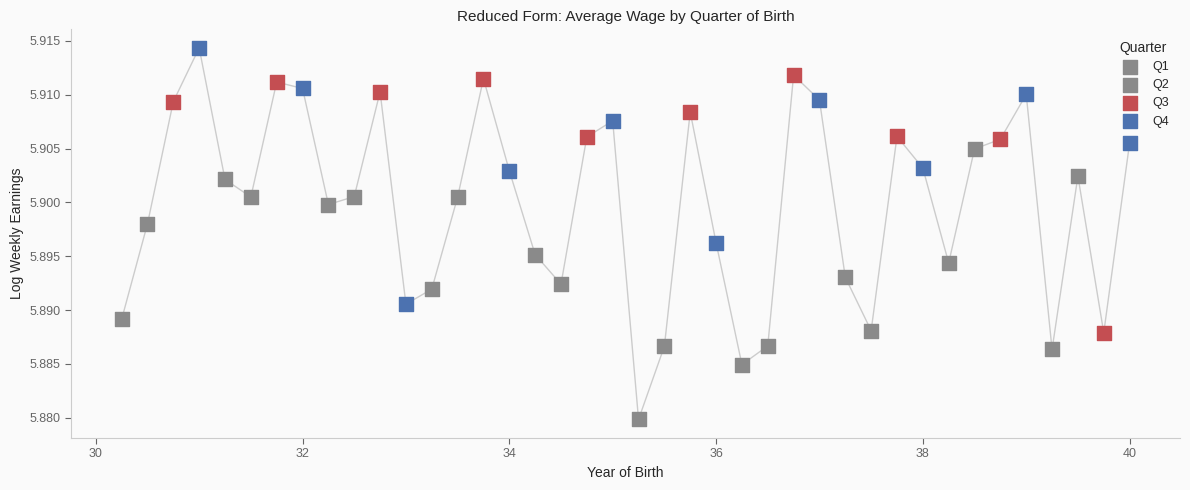

In [6]:
# Visualize reduced form: seasonal pattern in wages
fig, ax = create_tufte_figure(figsize=(12, 5))

ax.plot(group_data['time_of_birth'], group_data['log_wage'], 
        color=TUFTE_PALETTE['spine'], zorder=-1, linewidth=1)

for q in range(1, 5):
    subset = group_data.query(f'quarter_of_birth == {q}')
    ax.scatter(subset['time_of_birth'], subset['log_wage'], 
               s=100, c=colors[q-1], marker='s', label=f'Q{q}', zorder=2)

ax.set_xlabel('Year of Birth')
ax.set_ylabel('Log Weekly Earnings')
ax.set_title('Reduced Form: Average Wage by Quarter of Birth')
ax.legend(frameon=False, title='Quarter')

plt.tight_layout()
plt.show()

In [7]:
# Reduced form regression
reduced_form = smf.ols(
    'log_wage ~ C(year_of_birth) + C(state_of_birth) + q4',
    data=data
).fit()

print("REDUCED FORM: log_wage ~ q4 + controls")
print("=" * 50)
print(f"q4 coefficient: {reduced_form.params['q4']:.6f}")
print(f"q4 std error:   {reduced_form.bse['q4']:.6f}")
print(f"q4 t-statistic: {reduced_form.tvalues['q4']:.2f}")
print(f"q4 p-value:     {reduced_form.pvalues['q4']:.4f}")
print(f"\nInterpretation: Those born in Q4 have {100*reduced_form.params['q4']:.2f}% higher wages")

REDUCED FORM: log_wage ~ q4 + controls
q4 coefficient: 0.008603
q4 std error:   0.002709
q4 t-statistic: 3.18
q4 p-value:     0.0015

Interpretation: Those born in Q4 have 0.86% higher wages


### 3.4 IV by Hand vs Proper 2SLS

In [8]:
# IV by hand: Reduced Form / First Stage
iv_by_hand = reduced_form.params['q4'] / first_stage.params['q4']

print("IV BY HAND")
print("=" * 50)
print(f"Reduced Form (effect of q4 on log_wage): {reduced_form.params['q4']:.6f}")
print(f"First Stage (effect of q4 on education): {first_stage.params['q4']:.6f}")
print(f"IV estimate = RF / FS = {iv_by_hand:.6f}")
print(f"\nInterpretation: Each year of education increases wages by {100*iv_by_hand:.1f}%")

IV BY HAND
Reduced Form (effect of q4 on log_wage): 0.008603
First Stage (effect of q4 on education): 0.100858
IV estimate = RF / FS = 0.085303

Interpretation: Each year of education increases wages by 8.5%


In [9]:
# Manual 2SLS (wrong SEs!)
data_with_fitted = data.assign(years_of_schooling_fitted=first_stage.fittedvalues)

manual_2sls = smf.ols(
    'log_wage ~ C(year_of_birth) + C(state_of_birth) + years_of_schooling_fitted',
    data=data_with_fitted
).fit()

print("\nMANUAL 2SLS (Wrong Standard Errors!)")
print("=" * 50)
print(f"Coefficient: {manual_2sls.params['years_of_schooling_fitted']:.6f}")
print(f"Std Error:   {manual_2sls.bse['years_of_schooling_fitted']:.6f} (WRONG!)")


MANUAL 2SLS (Wrong Standard Errors!)
Coefficient: 0.085303
Std Error:   0.026861 (WRONG!)


In [10]:
# Proper 2SLS with linearmodels
formula = 'log_wage ~ 1 + C(year_of_birth) + C(state_of_birth) + [years_of_schooling ~ q4]'
proper_2sls = IV2SLS.from_formula(formula, data).fit()

print("\nPROPER 2SLS (linearmodels)")
print("=" * 50)
print(f"Coefficient: {proper_2sls.params['years_of_schooling']:.6f}")
print(f"Std Error:   {proper_2sls.std_errors['years_of_schooling']:.6f}")
print(f"95% CI:      [{proper_2sls.conf_int().loc['years_of_schooling', 'lower']:.4f}, "
      f"{proper_2sls.conf_int().loc['years_of_schooling', 'upper']:.4f}]")
print(f"p-value:     {proper_2sls.pvalues['years_of_schooling']:.4f}")


PROPER 2SLS (linearmodels)
Coefficient: 0.085303
Std Error:   0.025541
95% CI:      [0.0352, 0.1354]
p-value:     0.0008


In [11]:
# Compare with OLS
ols = smf.ols(
    'log_wage ~ years_of_schooling + C(year_of_birth) + C(state_of_birth) + C(quarter_of_birth)',
    data=data
).fit()

print("\nCOMPARISON: OLS vs 2SLS")
print("=" * 60)
print(f"{'Method':<15} {'Coefficient':>12} {'SE':>12} {'95% CI':>25}")
print("-" * 60)
print(f"{'OLS':<15} {ols.params['years_of_schooling']:>12.4f} {ols.bse['years_of_schooling']:>12.4f} "
      f"[{ols.conf_int().loc['years_of_schooling', 0]:.4f}, {ols.conf_int().loc['years_of_schooling', 1]:.4f}]")
print(f"{'2SLS':<15} {proper_2sls.params['years_of_schooling']:>12.4f} {proper_2sls.std_errors['years_of_schooling']:>12.4f} "
      f"[{proper_2sls.conf_int().loc['years_of_schooling', 'lower']:.4f}, {proper_2sls.conf_int().loc['years_of_schooling', 'upper']:.4f}]")


COMPARISON: OLS vs 2SLS
Method           Coefficient           SE                    95% CI
------------------------------------------------------------
OLS                   0.0673       0.0003 [0.0666, 0.0680]
2SLS                  0.0853       0.0255 [0.0352, 0.1354]


In [12]:
# Verify all three methods give same point estimate
print("\nVERIFICATION: All methods give same point estimate")
print("=" * 50)
print(f"IV by hand (RF/FS):     {iv_by_hand:.10f}")
print(f"Manual 2SLS:            {manual_2sls.params['years_of_schooling_fitted']:.10f}")
print(f"Proper 2SLS:            {proper_2sls.params['years_of_schooling']:.10f}")
all_match = np.allclose([iv_by_hand, manual_2sls.params['years_of_schooling_fitted']], 
                        proper_2sls.params['years_of_schooling'], rtol=1e-6)
print(f"\nAll match: {all_match}")

# Assert for testing
assert np.isclose(iv_by_hand, proper_2sls.params['years_of_schooling'], rtol=1e-4)


VERIFICATION: All methods give same point estimate
IV by hand (RF/FS):     0.0853028649
Manual 2SLS:            0.0853028649
Proper 2SLS:            0.0853028649

All match: True


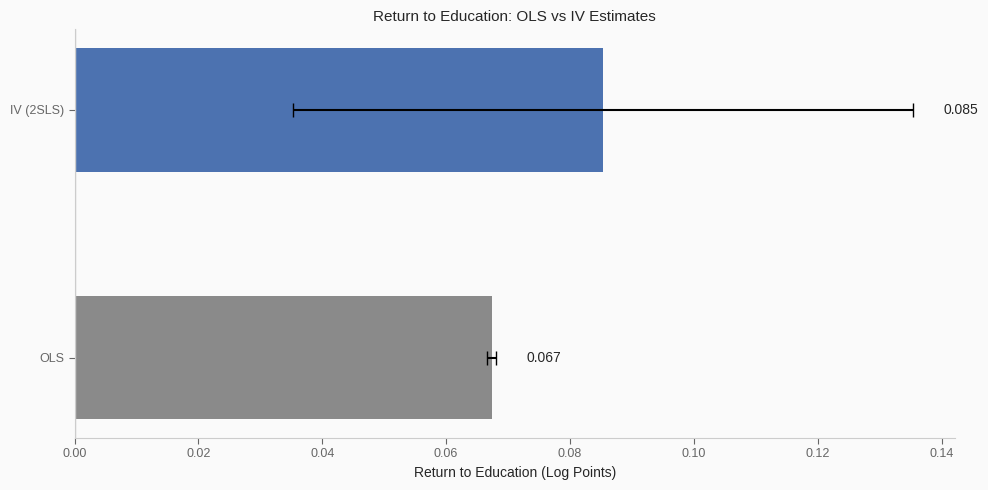


★ Key Finding:
  - OLS: 6.7% return per year
  - IV:  8.5% return per year
  - IV estimate is HIGHER, suggesting OLS may have downward bias
  - But IV CI is much wider (less precision)


In [13]:
# Visualize OLS vs IV comparison
fig, ax = create_tufte_figure(figsize=(10, 5))

methods = ['OLS', 'IV (2SLS)']
estimates = [ols.params['years_of_schooling'], proper_2sls.params['years_of_schooling']]
errors = [1.96 * ols.bse['years_of_schooling'], 
          1.96 * proper_2sls.std_errors['years_of_schooling']]

ax.barh(methods, estimates, xerr=errors, 
        color=[TUFTE_PALETTE['control'], TUFTE_PALETTE['treatment']], 
        capsize=5, height=0.5)
ax.axvline(0, color=TUFTE_PALETTE['spine'], linestyle='-', linewidth=1)
ax.set_xlabel('Return to Education (Log Points)')
ax.set_title('Return to Education: OLS vs IV Estimates')

# Add value labels
for i, (est, err) in enumerate(zip(estimates, errors)):
    ax.text(est + err + 0.005, i, f'{est:.3f}', va='center')

plt.tight_layout()
plt.show()

print("\n★ Key Finding:")
print(f"  - OLS: {100*ols.params['years_of_schooling']:.1f}% return per year")
print(f"  - IV:  {100*proper_2sls.params['years_of_schooling']:.1f}% return per year")
print(f"  - IV estimate is HIGHER, suggesting OLS may have downward bias")
print(f"  - But IV CI is much wider (less precision)")

---

## 4. Implementation

The 2SLS estimator is implemented in `causal_inference_mastery` at `src/causal_inference/iv/`:

```python
from causal_inference.iv.two_stage import TwoStageLeastSquares, IV2SLSResult

# Basic usage
model = TwoStageLeastSquares(
    formula='log_wage ~ [years_of_schooling ~ q1 + q2 + q3] + year_of_birth + state_of_birth'
)
result = model.fit(data)

print(f"Coefficient: {result.params['years_of_schooling']:.4f}")
print(f"First-stage F: {result.first_stage_f:.2f}")
print(f"Weak instrument? {result.first_stage_f < 10}")
```

The production code provides:
- Heteroskedasticity-robust standard errors
- Cluster-robust inference (for grouped data)
- First-stage F-statistic for weak instrument diagnostics
- Sargan-Hansen overidentification test (with multiple instruments)

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Google L5, Quant)**: *"Why does running 2SLS by hand give wrong standard errors?"*

<details>
<summary>Solution</summary>

**The problem:**

When computing residuals for the variance estimator, manual 2SLS uses:
$$\tilde{u}_i = y_i - \hat{\alpha}'X_i - \hat{\rho}\hat{s}_i$$

But the correct residuals should be:
$$\hat{u}_i = y_i - \hat{\alpha}'X_i - \hat{\rho}s_i$$

**Why this matters:**

1. $\hat{s}_i$ is a linear projection of $s_i$, so $\text{Var}(\hat{s}_i) < \text{Var}(s_i)$
2. Using $\hat{s}_i$ makes residuals artificially small
3. Smaller residuals → smaller variance estimate → understated SEs
4. Result: confidence intervals too narrow, p-values too small

**Solution**: Use proper 2SLS software that computes residuals using actual $s_i$ values.

</details>

---

**Q2 (Meta E5, DS)**: *"The 2SLS estimate of return to education is higher than OLS. What does this suggest about the direction of OVB?"*

<details>
<summary>Solution</summary>

**Observation**: OLS gives ~6.7%, IV gives ~8.5%

**Surprising result**: We'd expect OLS to be *upward* biased (ability → more education AND higher wages), but IV is *higher*.

**Possible explanations:**

1. **Measurement error in education**:
   - Education is self-reported → classical measurement error
   - Measurement error attenuates OLS toward zero
   - IV is robust to measurement error (only uses variation from Z)

2. **Local Average Treatment Effect (LATE)**:
   - IV estimates effect for "compliers" (those whose education changed due to quarter of birth)
   - Compliers are those at the margin of dropping out
   - Return to education may be *higher* for this marginal group

3. **Weak instrument bias**:
   - First-stage effect is small (0.1 years)
   - Weak instruments bias IV toward OLS → IV might be even higher without bias

**Key insight**: IV ≠ ATE in general. LATE interpretation is crucial.

</details>

---

**Q3 (Amazon L6, Econ)**: *"Show mathematically that 2SLS equals the ratio of reduced form to first stage coefficients."*

<details>
<summary>Solution</summary>

**With a single instrument** (just-identified case):

Let $\tilde{z}_i$ be the residual from regressing $z_i$ on controls $X_i$.

Then the 2SLS estimator can be written as:
$$\hat{\rho}_{2SLS} = \frac{\widehat{\text{Cov}}(y_i, \tilde{z}_i)}{\widehat{\text{Cov}}(s_i, \tilde{z}_i)}$$

**Step 1**: The numerator is the reduced form coefficient:
$$\frac{\widehat{\text{Cov}}(y_i, \tilde{z}_i)}{\widehat{\text{Var}}(\tilde{z}_i)} = \hat{\pi}_{21} \quad (\text{reduced form})$$

**Step 2**: The denominator is the first stage coefficient:
$$\frac{\widehat{\text{Cov}}(s_i, \tilde{z}_i)}{\widehat{\text{Var}}(\tilde{z}_i)} = \hat{\pi}_{11} \quad (\text{first stage})$$

**Step 3**: Therefore:
$$\hat{\rho}_{2SLS} = \frac{\hat{\pi}_{21}}{\hat{\pi}_{11}} = \frac{\text{Reduced Form}}{\text{First Stage}}$$

This is the **Indirect Least Squares (ILS)** representation, which equals 2SLS with a single instrument.

</details>

---

## 6. References

[^1]: Angrist, J. D. & Krueger, A. B. (1991). "Does Compulsory School Attendance Affect Schooling and Earnings?" *Quarterly Journal of Economics*, 106(4), 979-1014.

[^2]: Angrist, J. D. & Pischke, J.-S. (2009). *Mostly Harmless Econometrics*, Chapter 4. Princeton University Press. [research_kb: `93737674-d68d-4952-957f-00e26f085088`]

[^3]: Wooldridge, J. M. (2010). *Econometric Analysis of Cross Section and Panel Data*, Chapter 5. MIT Press. [research_kb: `24af0a79-be81-4c29-8426-fcc97ef1ec81`]

[^4]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 8: "Instrumental Variables."

---

**Precision Improvement:**
- You said: "Build the 2SLS notebook"
- Concise: "Build 02_two_stage_least_squares"
- Precise: `/augmented 08.2 --2sls --angrist-krueger --se-correction`
- Pattern: [build] [target] [content-flags]